In [2]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\adult\adult_data_GroundTruth.csv')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             45222 non-null  int64
 1   workclass       45222 non-null  int64
 2   fnlwgt          45222 non-null  int64
 3   education-num   45222 non-null  int64
 4   marital-status  45222 non-null  int64
 5   occupation      45222 non-null  int64
 6   relationship    45222 non-null  int64
 7   race            45222 non-null  int64
 8   sex             45222 non-null  int64
 9   capital-gain    45222 non-null  int64
 10  capital-loss    45222 non-null  int64
 11  hours-per-week  45222 non-null  int64
 12  native-country  45222 non-null  int64
 13  income          45222 non-null  int64
dtypes: int64(14)
memory usage: 4.8 MB


Learning the structure of the Bayesian Network...


  0%|          | 20/1000000 [00:04<57:50:11,  4.80it/s]


Bayesian Network Structure:
[('workclass', 'occupation'), ('workclass', 'race'), ('occupation', 'education-num'), ('race', 'native-country'), ('education-num', 'income'), ('education-num', 'relationship'), ('income', 'capital-gain'), ('relationship', 'marital-status'), ('relationship', 'income'), ('relationship', 'hours-per-week'), ('relationship', 'race'), ('marital-status', 'age'), ('marital-status', 'capital-loss'), ('marital-status', 'native-country'), ('sex', 'relationship'), ('sex', 'occupation'), ('sex', 'education-num'), ('sex', 'workclass'), ('sex', 'marital-status')]


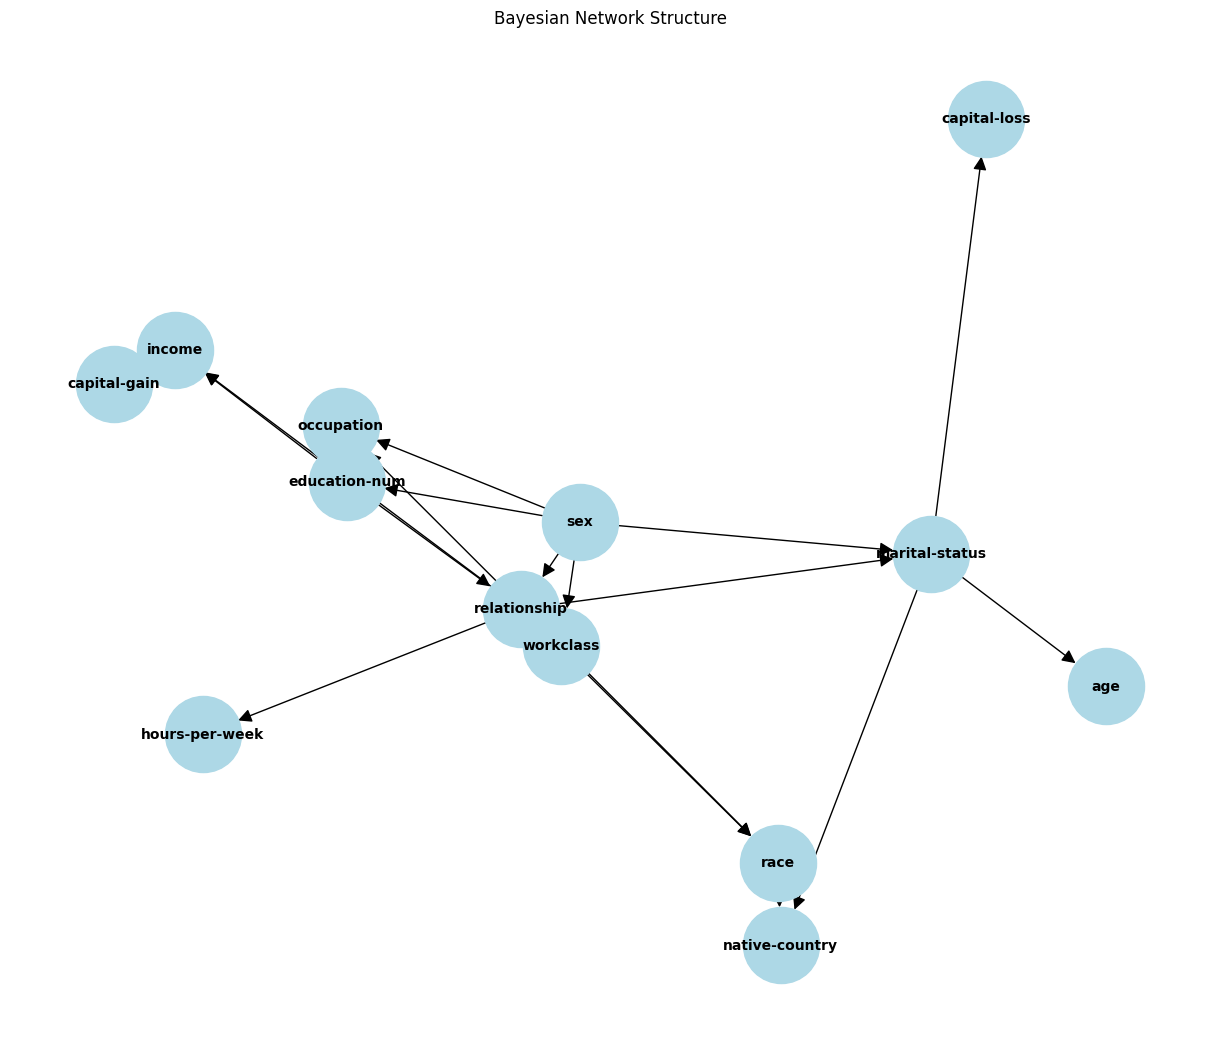

Fitting the Bayesian Network with data...


In [7]:



# Step 2: Identify missingness indicators
# Add missingness indicators for each column with missing values
'''''
missing_indicators = {}
for column in data.columns:
    if data[column].isnull().any():
        missing_indicators[f'R_{column}'] = data[column].isnull().astype(int)

# Add missingness indicators to the dataset
for key, value in missing_indicators.items():
    data[key] = value

'''''

# Drop rows with missing values temporarily for structure learning
data_complete = data.dropna()

print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data)
model = hc.estimate(scoring_method=BicScore(data))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [8]:
inference = VariableElimination(bayesian_net)



# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["sex", "marital-status","relationship"])
print("\nJoint Probability")
print(query_result)



Joint Probability
+--------+-------------------+-----------------+----------------------------------------+
| sex    | marital-status    | relationship    |   phi(sex,marital-status,relationship) |
+========+===================+=================+========================================+
| sex(1) | marital-status(1) | relationship(1) |                                 0.4128 |
+--------+-------------------+-----------------+----------------------------------------+
| sex(1) | marital-status(1) | relationship(2) |                                 0.0019 |
+--------+-------------------+-----------------+----------------------------------------+
| sex(1) | marital-status(1) | relationship(3) |                                 0.0029 |
+--------+-------------------+-----------------+----------------------------------------+
| sex(1) | marital-status(1) | relationship(4) |                                 0.0054 |
+--------+-------------------+-----------------+---------------------------------

In [9]:
result = inference.query(variables=["workclass"], evidence={"sex": True})
print("Conditional Probability P(workclass | sex=True):")
print(result)

Conditional Probability P(workclass | sex=True):
+--------------+------------------+
| workclass    |   phi(workclass) |
+==============+==================+
| workclass(1) |           0.1313 |
+--------------+------------------+
| workclass(2) |           0.7167 |
+--------------+------------------+
| workclass(3) |           0.1515 |
+--------------+------------------+
| workclass(4) |           0.0005 |
+--------------+------------------+


In [10]:
query_result = inference.query(variables=["sex", "occupation"])
print("\nJoint Probability:")
print(query_result)


Joint Probability:
+--------+---------------+-----------------------+
| sex    | occupation    |   phi(sex,occupation) |
+========+===============+=======================+
| sex(1) | occupation(1) |                0.2184 |
+--------+---------------+-----------------------+
| sex(1) | occupation(2) |                0.2930 |
+--------+---------------+-----------------------+
| sex(1) | occupation(3) |                0.1637 |
+--------+---------------+-----------------------+
| sex(2) | occupation(1) |                0.1693 |
+--------+---------------+-----------------------+
| sex(2) | occupation(2) |                0.0350 |
+--------+---------------+-----------------------+
| sex(2) | occupation(3) |                0.1207 |
+--------+---------------+-----------------------+


In [11]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['workclass', 'occupation', 'race', 'education-num', 'income', 'relationship', 'marital-status', 'age', 'capital-loss', 'native-country', 'hours-per-week', 'sex', 'capital-gain']
Edges in the Bayesian Network:
[('workclass', 'occupation'), ('workclass', 'race'), ('occupation', 'education-num'), ('race', 'native-country'), ('education-num', 'income'), ('education-num', 'relationship'), ('income', 'capital-gain'), ('relationship', 'marital-status'), ('relationship', 'income'), ('relationship', 'hours-per-week'), ('relationship', 'race'), ('marital-status', 'age'), ('marital-status', 'capital-loss'), ('marital-status', 'native-country'), ('sex', 'relationship'), ('sex', 'occupation'), ('sex', 'education-num'), ('sex', 'workclass'), ('sex', 'marital-status')]
